# Predict Future Sales

Second part of feauture enginering and ML modeling - testing advanced models and advanced features

kaggle link : https://www.kaggle.com/c/competitive-data-science-predict-future-sales/overview

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns; sns.set()
from dateutil.relativedelta import relativedelta

In [2]:
from my_functions import merge_basic, convert_silver, completion_semi_gold, scaler, inversed_scale, consolidation_prediction, plot_prediction, preparing_to_predict, plot_metrics

In [3]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import mean_squared_error

### Data

In [4]:
daily_train = pd.read_csv('sales_train.csv')
items = pd.read_csv('items.csv')
shops = pd.read_csv('shops.csv')
categories = pd.read_csv('item_categories.csv')
sample_submission = pd.read_csv('sample_submission.csv')
test = pd.read_csv('test.csv')

### Data modeling

In [5]:
train_merge = merge_basic(daily_train, test)

In [6]:
train_merge.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name,ID,SaleDate
0,02.01.2013,0,59,22154,999.0,1.0,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray,150983,2013-01-02
1,03.01.2013,0,25,2574,399.0,2.0,DEL REY LANA Born To Die The Paradise Editio...,55,Музыка - CD локального производства,56520,2013-01-03
2,05.01.2013,0,25,2574,399.0,1.0,DEL REY LANA Born To Die The Paradise Editio...,55,Музыка - CD локального производства,56520,2013-01-05
3,07.01.2013,0,25,2574,399.0,1.0,DEL REY LANA Born To Die The Paradise Editio...,55,Музыка - CD локального производства,56520,2013-01-07
4,08.01.2013,0,25,2574,399.0,2.0,DEL REY LANA Born To Die The Paradise Editio...,55,Музыка - CD локального производства,56520,2013-01-08


In [7]:
wholedata_silver = convert_silver(train_merge)

In [8]:
wholedata_silver.head()

,SaleDateMY,date_block_num,shop_id,item_id,item_category_name,item_category_id,item_cnt_day,shopitem
0,2013-01-01,0,2,33,Кино - Blu-Ray,37,1.0,2-33
1,2013-01-01,0,2,482,Программы - 1С:Предприятие 8,73,1.0,2-482
2,2013-01-01,0,2,491,Программы - 1С:Предприятие 8,73,1.0,2-491
3,2013-01-01,0,2,839,Программы - 1С:Предприятие 8,73,1.0,2-839
4,2013-01-01,0,2,1007,Подарки - Развитие,67,3.0,2-1007


<b> Splitting strategy:

* time series expanding window of one period, Take 7 months
* over the first fold, make the functions and features for modeling and prediction (avoid leakage)
* lags and seasons are features
* use rmse as metric
* consider the outputs of the EDA
* goal, predict november or yyyy-11-01

#### The validation data

In [9]:
wholedata_silver.SaleDateMY.max()

Timestamp('2015-10-01 00:00:00')

In [10]:
test_dates = [datetime.datetime(2014, 11, 1), datetime.datetime(2015, 4, 1), datetime.datetime(2015, 5, 1), datetime.datetime(2015, 6, 1), datetime.datetime(2015, 7, 1), datetime.datetime(2015, 8, 1),
datetime.datetime(2015, 9, 1), datetime.datetime(2015, 10, 1),]

In [11]:
whole_test_data = wholedata_silver[wholedata_silver.SaleDateMY.isin(test_dates)][['SaleDateMY','date_block_num','shop_id','item_id','item_cnt_day']]

#### hold-out Train

In [12]:
date_val = datetime.datetime(2014, 10, 1)

In [13]:
train_window = wholedata_silver[wholedata_silver.SaleDateMY < date_val ].copy()
val_window = wholedata_silver[wholedata_silver.SaleDateMY == date_val ][['SaleDateMY','shop_id','item_id','item_category_id', 'item_category_name','item_cnt_day']].copy()

In [14]:
train_window.head()

,SaleDateMY,date_block_num,shop_id,item_id,item_category_name,item_category_id,item_cnt_day,shopitem
0,2013-01-01,0,2,33,Кино - Blu-Ray,37,1.0,2-33
1,2013-01-01,0,2,482,Программы - 1С:Предприятие 8,73,1.0,2-482
2,2013-01-01,0,2,491,Программы - 1С:Предприятие 8,73,1.0,2-491
3,2013-01-01,0,2,839,Программы - 1С:Предприятие 8,73,1.0,2-839
4,2013-01-01,0,2,1007,Подарки - Развитие,67,3.0,2-1007


In [15]:
train_window.SaleDateMY.max(), train_window.SaleDateMY.min()

(Timestamp('2014-09-01 00:00:00'), Timestamp('2013-01-01 00:00:00'))

In [16]:
train_full = completion_semi_gold(train_window)

In [17]:
train_full.head()

,shop_id,item_id,shopitem,item_category_id,Date,Sale,Order
0,2,30,2-30,40,2013-01-01,0.0,1
1,2,31,2-31,37,2013-01-01,0.0,1
2,2,32,2-32,40,2013-01-01,0.0,1
3,2,33,2-33,37,2013-01-01,1.0,1
4,2,76,2-76,37,2013-01-01,0.0,1


In [18]:
train_full.sort_values('Sale', ascending = False)

,shop_id,item_id,shopitem,item_category_id,Date,Sale,Order
658884,31,20949,31-20949,71,2013-12-01,1305.0,12
653297,25,20949,25-20949,71,2013-12-01,1066.0,12
601679,31,20949,31-20949,71,2013-11-01,989.0,11
544474,31,20949,31-20949,71,2013-10-01,978.0,10
487269,31,20949,31-20949,71,2013-09-01,950.0,9
...,...,...,...,...,...,...,...
409882,12,6740,12-6740,30,2013-08-01,-2.0,8
581285,12,3734,12-3734,23,2013-11-01,-2.0,11
409538,12,1829,12-1829,28,2013-08-01,-2.0,8
56799,59,14931,59-14931,69,2013-01-01,-2.0,1


### Exploration of the features

<b> scalling shopitem wise over L 1 differenciation per shopitem

In [30]:
def feature_silver(data):
    data = data.copy()
    ## feature of diff using one lag
    data['SaleL1M'] = data.sort_values('Date').groupby(['shopitem'])['Sale'].shift(1)
    data['SaleL2M'] = data.sort_values('Date').groupby(['shopitem'])['Sale'].shift(2)
    data['SaleL3M'] = data.sort_values('Date').groupby(['shopitem'])['Sale'].shift(3)
    data['SaleL4M'] = data.sort_values('Date').groupby(['shopitem'])['Sale'].shift(4)
    data['SaleL11M'] = data.sort_values('Date').groupby(['shopitem'])['Sale'].shift(11)
    data['SaleL12M'] = data.sort_values('Date').groupby(['shopitem'])['Sale'].shift(12)
    data['SaleL13M'] = data.sort_values('Date').groupby(['shopitem'])['Sale'].shift(13)
    
    data_lagdiff = data.assign(L0M_L1M = data.Sale - data.SaleL1M)  ### This is new target ???? but yeaaaaaHHH
    data_lagdiff = data_lagdiff.assign(L1M_L2M = data_lagdiff.SaleL1M - data_lagdiff.SaleL2M) 
    data_lagdiff = data_lagdiff.assign(L2M_L3M = data_lagdiff.SaleL2M - data_lagdiff.SaleL3M)
    data_lagdiff = data_lagdiff.assign(L3M_L4M = data_lagdiff.SaleL3M - data_lagdiff.SaleL4M)
    
    data_lagdiff = data_lagdiff.assign(L1M_L11M = data_lagdiff.SaleL1M - data_lagdiff.SaleL11M)
    data_lagdiff = data_lagdiff.assign(L1M_L12M = data_lagdiff.SaleL1M - data_lagdiff.SaleL12M)
    data_lagdiff = data_lagdiff.assign(L1M_L13M = data_lagdiff.SaleL1M - data_lagdiff.SaleL13M)
    
    data_lagdiff = data_lagdiff.drop(columns = ['SaleL2M','SaleL3M','SaleL3M','SaleL4M', 'SaleL11M', 'SaleL12M', 'SaleL13M'])
    
    ### Categorical price
    data_lagdiff = data_lagdiff.assign(categVolume = np.where( data_lagdiff.SaleL1M > 100, 'A',
                                                np.where( data_lagdiff.SaleL1M > 70, 'B',
                                                np.where( data_lagdiff.SaleL1M > 30, 'C',
                                                np.where( data_lagdiff.SaleL1M > 10, 'D',
                                                np.where( data_lagdiff.SaleL1M > 5, 'F',
                                                np.where( data_lagdiff.SaleL1M >= 3, 'G','H'
                                                         )))))))
    
    ### Categorical completion
    data_lagdiff = data_lagdiff.assign( possCounts = np.where(data_lagdiff.Sale > 0, 1, 0) )
    data_lagdiff['possCounts'] = data_lagdiff.groupby(['shopitem']).possCounts.transform(lambda x: x.sum())
    data_lagdiff = data_lagdiff.assign(categSale = np.where( data_lagdiff.possCounts > 10, 'A',
                                                np.where( data_lagdiff.possCounts > 5, 'B',
                                                np.where( data_lagdiff.possCounts > 3, 'C',
                                                np.where( data_lagdiff.possCounts <= 3, 'D','D'
                                                        )))))
    
    #focussed max shop
    data_lagdiff['maxSection'] = data_lagdiff.groupby(['shop_id','categSale']).Sale.transform('max')
    
    ### furhter lags in function of diff
    data_lagdiff['L11M'] = data_lagdiff.sort_values('Date').groupby(['shopitem'])['L1M_L2M'].shift(11)
    data_lagdiff['L12M'] = data_lagdiff.sort_values('Date').groupby(['shopitem'])['L1M_L2M'].shift(12)
    data_lagdiff['L13M'] = data_lagdiff.sort_values('Date').groupby(['shopitem'])['L1M_L2M'].shift(13)
     
    ## Count zeros
    data_lagdiff['count0'] = np.where(data_lagdiff.SaleL1M == 0,1,0)
    data_lagdiff['Roll0count'] = data_lagdiff.sort_values('Date').groupby(['shopitem']).count0.transform(lambda x: x.rolling(4, 1).sum())
    data_lagdiff = data_lagdiff.drop(columns = ['count0'])
    ## Count no variations
    data_lagdiff['count0'] = np.where(data_lagdiff.L1M_L2M == 0,1,0)
    data_lagdiff['Roll0L1'] = data_lagdiff.sort_values('Date').groupby(['shopitem']).count0.transform(lambda x: x.rolling(4, 1).sum())
    #data_lagdiff['Roll0L1Mean'] = data_lagdiff.sort_values('Date').groupby(['shopitem']).Roll0L1.transform(lambda x: x.rolling(4, 1).mean())
    data_lagdiff = data_lagdiff.drop(columns = ['count0'])
    
    ## addition lags
    data_lagdiff['Roll0L1L6'] = data_lagdiff.sort_values('Date').groupby(['shopitem'])['Roll0L1'].shift(6)
    data_lagdiff['Roll0L1L12'] = data_lagdiff.sort_values('Date').groupby(['shopitem'])['Roll0L1'].shift(12)
    data_lagdiff['Roll0countL6'] = data_lagdiff.sort_values('Date').groupby(['shopitem'])['Roll0count'].shift(6)
    data_lagdiff['Roll0countL12'] = data_lagdiff.sort_values('Date').groupby(['shopitem'])['Roll0count'].shift(12)
    
    ## month
    data_lagdiff = data_lagdiff.assign(month = data_lagdiff.Date.dt.month)
    ## year
    data_lagdiff['Year'] = data_lagdiff.Date.dt.year
    ## quarter
    data_lagdiff['Quarter'] = np.where(data_lagdiff.month.isin([1,2,3]),1,
                            np.where(data_lagdiff.month.isin([4,5,6]),2,
                            np.where(data_lagdiff.month.isin([7,8,9]),3,
                            np.where(data_lagdiff.month.isin([10,11,12]),4,0))))
    
    
    ####################################
    ### Features for explosion items ###
    ####################################
    data_lagdiff['maxVar'] = data_lagdiff.groupby(['shopitem']).L1M_L2M.transform('max')
    data_lagdiff['minVar'] = data_lagdiff.groupby(['shopitem']).L1M_L2M.transform('min')

    data_lagdiff = data_lagdiff.assign( noVar = np.where(data_lagdiff.L1M_L2M == 0, 1, 0) )
    data_lagdiff['countNoVar'] = data_lagdiff.groupby(['shopitem']).noVar.transform('sum')
    
    data_lagdiff['FlagShop'] = np.where((data_lagdiff.maxVar > 10) & (data_lagdiff.minVar < 2), data_lagdiff.shop_id, 0)
    data_lagdiff['FlagCategory'] = np.where((data_lagdiff.maxVar > 10) & (data_lagdiff.minVar < 2), data_lagdiff.item_category_id, 0)
    
    data_lagdiff = data_lagdiff.assign(possitionMax = np.where( data_lagdiff.L1M_L2M == data_lagdiff.maxVar, data_lagdiff.Order, 0))
    data_lagdiff['pivotx'] = data_lagdiff.groupby(['shopitem']).possitionMax.transform('max')
    data_lagdiff = data_lagdiff.assign(befExplotion = np.where(data_lagdiff.Order < data_lagdiff.pivotx , 1, 0))
    data_lagdiff['SumBefExplotion'] = data_lagdiff.groupby(['shopitem']).befExplotion.transform('sum')
    
    data_lagdiff = data_lagdiff.drop(columns = ['pivotx','possitionMax'])
    
    ## interaction
    data_lagdiff['countNoVar'] = data_lagdiff['noVar'] * data_lagdiff['countNoVar']
    data_lagdiff['FlagShop'] = data_lagdiff['noVar'] * data_lagdiff['FlagShop']
    data_lagdiff['FlagCategory'] = data_lagdiff['noVar'] * data_lagdiff['FlagCategory']
    data_lagdiff['befExplotion'] = data_lagdiff['noVar'] * data_lagdiff['befExplotion']
    data_lagdiff['SumBefExplotion'] = data_lagdiff['noVar'] * data_lagdiff['SumBefExplotion']
    
    ####################################
    ##### end ##########################
    ####################################
    
    ####################################
    ####### maps for feature gen #######
    ####################################
    
    data_lagdiff['maxVar'] = data_lagdiff.groupby(['shopitem']).L0M_L1M.transform('max')
    data_lagdiff['minVar'] = data_lagdiff.groupby(['shopitem']).L0M_L1M.transform('min')
    
    df_feature = data_lagdiff[(data_lagdiff.maxVar > 10) & (data_lagdiff.minVar < 2) ]\
    [['shop_id','item_id','shopitem','item_category_id','Date', 'Sale','Order', 'L0M_L1M','maxVar']].copy()

    df_feature['month'] = df_feature['Date'].dt.month
    df_feature['pivotDiff'] = np.where(df_feature.Sale == 0, 0,1)
    df_feature['reorder1'] = df_feature.sort_values(['Date'], ascending=[True]).groupby(['shopitem','pivotDiff']).cumcount() + 1
    df_feature['Starter'] = np.where((df_feature.pivotDiff == 1) & (df_feature.reorder1 == 1),df_feature.Order,0)

    df_feature['pivotMax'] = df_feature.groupby(['shopitem']).Starter.transform('max')
    df_feature['OrderBef'] = np.where(df_feature.Order < df_feature.pivotMax, df_feature.Order,0)
    df_feature['pivotSep'] = np.where(df_feature.OrderBef > 0 ,1,0)

    df_feature['reorder'] = df_feature.sort_values(['Date'], ascending=[True]).groupby(['shopitem','pivotSep']).cumcount() + 1
    df_feature['capture'] = np.where(df_feature.pivotSep == 1, 1,np.where((df_feature.pivotSep == 0) & (df_feature.reorder <= 3),1,0 ) )
    df_feature = df_feature[df_feature.capture == 1]

    feature_item = df_feature[(df_feature.pivotSep == 0) ].groupby(['item_id','reorder']).agg(meanVarExploItem = ('L0M_L1M','median')).reset_index()
    feature_item['reorder'] = feature_item['reorder'] - 1
    feature_shop = df_feature[(df_feature.pivotSep == 0) ].groupby(['shop_id','reorder']).agg(meanVarExploShop = ('L0M_L1M','median')).reset_index()
    feature_shop['reorder'] = feature_shop['reorder'] - 1
    feature_month = df_feature[df_feature.Starter != 0 ].groupby('month').agg(countMonth = ('L0M_L1M', 'count')).reset_index()
    
    features_dictionary = {'Item_feature': feature_item, 'Shop_feature': feature_shop, 'month_feature': feature_month}
    
    ####################################
    ##### end ##########################
    ####################################
    
    
    ###############################################
    ####### maps for feature highVariation #######
    ###############################################
    
    df_feature = data_lagdiff[['shop_id','item_id','shopitem','item_category_id','Date', 'Sale','Order', 'L0M_L1M','minVar','maxVar']].copy()
    df_feature['count0'] = np.where(df_feature.Sale == 0,1,0)
    df_feature['month'] = df_feature['Date'].dt.month
    df_feature['count0'] = df_feature.sort_values('Date').groupby(['shopitem']).count0.transform('sum')
    df_feature['SaleNew'] = np.where(df_feature.Sale == 0,np.nan, df_feature.Sale)
    df_feature['minSale'] = df_feature.sort_values('Date').groupby(['shopitem']).SaleNew.transform('min')
    
    df_feature = df_feature[(abs(df_feature.maxVar) > 3) &(df_feature.count0 < 6)]
    
    def q2(x):
        return x.quantile(0.50)

    def q3(x):
        return x.quantile(0.95)

    df_feature['Year'] = df_feature.Date.dt.year
    df_feature['Quarter'] = np.where(df_feature.month.isin([1,2,3]),1,
                            np.where(df_feature.month.isin([4,5,6]),2,
                            np.where(df_feature.month.isin([7,8,9]),3,
                            np.where(df_feature.month.isin([10,11,12]),4,0))))

    feature_med = df_feature.groupby(['item_id','Order','Year','Quarter','month']).agg(medianVar = ('L0M_L1M',q2),
                                                                 highVar = ('L0M_L1M',q3)).reset_index()
    feature_med['HighMeanQuart'] = feature_med.groupby(['Year','Quarter']).highVar.transform('mean')
    feature_med['medianVarL12'] = feature_med.sort_values('Order').groupby(['item_id'])['medianVar'].shift(12)
    feature_med['HighVarL12'] = feature_med.sort_values('Order').groupby(['item_id'])['highVar'].shift(12)

    feature_var_season = feature_med.groupby(['item_id','Year','Quarter'])[['HighMeanQuart']].max().reset_index()
    feature_var_season['HighMeanQuartL4'] = feature_var_season.sort_values(['Year','Quarter']).groupby(['item_id'])['HighMeanQuart'].shift(4)
    feature_var_season = feature_var_season.fillna(0)
    feature_var_season['SeasonalVariation'] = feature_var_season.HighMeanQuart - feature_var_season.HighMeanQuartL4
    feature_var_season = feature_var_season.drop(columns = 'HighMeanQuart')


    feature_med = feature_med.merge(feature_var_season, on = ['item_id','Year','Quarter'],how = 'left')
    feature_med = feature_med[['item_id','Order','Year','month','medianVarL12','SeasonalVariation','HighVarL12']]
    
    features_dictionary['HighVarSeason'] = feature_med
    ####################################
    ##### end ##########################
    ####################################
    
    data_lagdiff = data_lagdiff.drop(columns = ['maxVar','minVar'])
    data_result = data_lagdiff
    return data_result, features_dictionary

In [33]:
def integration_new_features_map(data, dict_feature):
    
    data_wow = data.copy()
    data_wow['maxVar'] = data_wow.groupby(['shopitem']).L1M_L2M.transform('max')
    data_wow['minVar'] = data_wow.groupby(['shopitem']).L1M_L2M.transform('min')
    
    ##### detector ######
    
    data_wow['labeling'] = np.where((data_wow.maxVar > 10) & (data_wow.minVar < 2),1,0)
    data_wow['labeling'] = data_wow.groupby(['shopitem']).labeling.transform('max')
    data_wow['pivotDiff'] = np.where(data_wow.Sale == 0, 0,1)
    data_wow['reorder'] = data_wow.sort_values(['Date'], ascending=[True]).groupby(['shopitem','pivotDiff']).cumcount() + 1
    data_wow['reorder'] = data_wow['reorder']*data_wow['pivotDiff']
    data_wow['reorder'] = data_wow.sort_values('Date').groupby(['shopitem'])['reorder'].shift(1)
    
    #### mergin
    
    data_wow = data_wow.merge(features_dictionary['Item_feature'], on = ['item_id','reorder'], how = 'left')
    data_wow = data_wow.merge(features_dictionary['Shop_feature'], on = ['shop_id','reorder'], how = 'left')
    data_wow = data_wow.merge(features_dictionary['month_feature'], on = ['month'], how = 'left')
    data_wow = data_wow.merge(features_dictionary['HighVarSeason'], on = ['item_id','Year','month','Order'], how = 'left')
    
    ### feature correction
    data_wow['meanVarExploItem'] = np.where(data_wow['labeling'] == 1, data_wow['meanVarExploItem'],0 )
    data_wow['meanVarExploShop'] = np.where(data_wow['labeling'] == 1, data_wow['meanVarExploShop'],0 )
    data_wow['countMonth'] = np.where(data_wow['labeling'] == 1, data_wow['countMonth'],0 )
    
    data_wow = data_wow.drop(columns = ['maxVar','minVar','pivotDiff','reorder'])
    
    return data_wow

In [34]:
train_feature, features_dictionary = feature_silver(train_full)
train_feature = integration_new_features_map(data = train_feature, dict_feature= features_dictionary) 

In [35]:
## Examples to test
## train_feature[(train_feature.item_id == 30) & (train_feature.shop_id == 2)]
## train_feature[(train_feature.item_id == 20949) & (train_feature.shop_id == 31)]

In [36]:
df_test = train_feature[(train_feature.item_id == 4382) & (train_feature.shop_id == 42)]
df_test.head()

,shop_id,item_id,shopitem,item_category_id,Date,Sale,Order,SaleL1M,L0M_L1M,L1M_L2M,...,FlagCategory,befExplotion,SumBefExplotion,labeling,meanVarExploItem,meanVarExploShop,countMonth,medianVarL12,SeasonalVariation,HighVarL12
36895,42,4382,42-4382,40,2013-01-01,0.0,1,NaN,NaN,NaN,...,0,0,0,0,0.0,0.0,0,NaN,NaN,NaN
94100,42,4382,42-4382,40,2013-02-01,0.0,2,0.0,0.0,NaN,...,0,0,0,0,0.0,0.0,0,NaN,NaN,NaN
151305,42,4382,42-4382,40,2013-03-01,0.0,3,0.0,0.0,0.0,...,0,1,10,0,0.0,0.0,0,NaN,NaN,NaN
208510,42,4382,42-4382,40,2013-04-01,0.0,4,0.0,0.0,0.0,...,0,1,10,0,0.0,0.0,0,NaN,NaN,NaN
265715,42,4382,42-4382,40,2013-05-01,0.0,5,0.0,0.0,0.0,...,0,1,10,0,0.0,0.0,0,NaN,NaN,NaN


In [37]:
features_dictionary['HighVarSeason'].head()

,item_id,Order,Year,month,medianVarL12,SeasonalVariation,HighVarL12
0,30,1,2013,1,NaN,3.304620,NaN
1,30,2,2013,2,NaN,3.304620,NaN
2,30,3,2013,3,NaN,3.304620,NaN
3,30,4,2013,4,NaN,2.756491,NaN
4,30,5,2013,5,NaN,2.756491,NaN


In [38]:
def features_rows_train_silver(data, features, target, dates_back = 5):
    
    ### splits
    ### conventional for regular time series
    
    cutoff = 5
    max_date = data.Date.max()
    min_date = max_date - relativedelta(days=dates_back)
    data_result_part1 = data[ (data.possCounts > cutoff) & (data.Date >= min_date) & (data.Date <= max_date)][features + [target]]
    
    max_date = data.Date.max() - relativedelta(months=6)
    min_date = max_date - relativedelta(days=dates_back)
    data_result_part2 = data[ (data.possCounts > cutoff) & (data.Date >= min_date) & (data.Date <= max_date)][features + [target]]
    
    ### until here we just covered a very little section
    max_date = data.Date.max()
    min_date = max_date - relativedelta(days=dates_back)
    data_result_part3 = data[ (data.possCounts <= cutoff) & (data.Date >= min_date) & (data.Date <= max_date)][features + [target]]
    
    max_date = data.Date.max() - relativedelta(months=3)
    min_date = max_date - relativedelta(days=dates_back)
    data_result_part4 = data[ (data.possCounts <= cutoff) & (data.Date >= min_date) & (data.Date <= max_date)][features + [target]]
    
    max_date = data.Date.max() - relativedelta(months=6)
    min_date = max_date - relativedelta(days=dates_back)
    data_result_part5 = data[ (data.possCounts <= cutoff) & (data.Date >= min_date) & (data.Date <= max_date)][features + [target]]
    
    ## concat results 
    data_result = pd.concat([data_result_part1, data_result_part2, data_result_part3, data_result_part4, data_result_part5], axis = 0).fillna(0)
    ### Result
    features_new = list(data_result.columns)
    features_new.remove(target)
    data_result = data_result[features_new + [target]]
    
    return data_result

In [39]:
train_feature.columns

Index(['shop_id', 'item_id', 'shopitem', 'item_category_id', 'Date', 'Sale',
       'Order', 'SaleL1M', 'L0M_L1M', 'L1M_L2M', 'L2M_L3M', 'L3M_L4M',
       'L1M_L11M', 'L1M_L12M', 'L1M_L13M', 'categVolume', 'possCounts',
       'categSale', 'maxSection', 'L11M', 'L12M', 'L13M', 'Roll0count',
       'Roll0L1', 'Roll0L1L6', 'Roll0L1L12', 'Roll0countL6', 'Roll0countL12',
       'month', 'Year', 'Quarter', 'noVar', 'countNoVar', 'FlagShop',
       'FlagCategory', 'befExplotion', 'SumBefExplotion', 'labeling',
       'meanVarExploItem', 'meanVarExploShop', 'countMonth', 'medianVarL12',
       'SeasonalVariation', 'HighVarL12'],
      dtype='object')

In [40]:
to_drop_columns = ['Date','Sale','SaleL1M']
numericals = ['L1M_L2M', 'L2M_L3M', 'L3M_L4M','L1M_L11M', 'L1M_L12M', 'L1M_L13M', 'possCounts','maxSection', 'L11M', 'L12M', 'L13M', 'Roll0count',
       'Roll0L1', 'Roll0L1L6', 'Roll0L1L12', 'Roll0countL6', 'Roll0countL12','month', 'Year', 'Quarter', 'noVar', 'countNoVar', 'FlagShop',
       'FlagCategory', 'befExplotion', 'SumBefExplotion', 'labeling','meanVarExploItem', 'meanVarExploShop', 'countMonth', 'medianVarL12',
       'SeasonalVariation', 'HighVarL12' ]
categoricals = ['categVolume', 'categSale']
my_features = to_drop_columns + numericals + categoricals
my_target = 'L0M_L1M'
len(my_features) - 3

35

In [41]:
train_selection = features_rows_train_silver(data = train_feature, features = my_features, target = my_target, dates_back = 6)

In [42]:
train_selection.head()

,Date,Sale,SaleL1M,L1M_L2M,L2M_L3M,L3M_L4M,L1M_L11M,L1M_L12M,L1M_L13M,possCounts,...,labeling,meanVarExploItem,meanVarExploShop,countMonth,medianVarL12,SeasonalVariation,HighVarL12,categVolume,categSale,L0M_L1M
1144106,2014-09-01,2.0,0.0,-1.0,1.0,0.0,-1.0,-2.0,0.0,15,...,0,0.0,0.0,0,0.5,-0.257481,8.95,H,A,2.0
1144108,2014-09-01,0.0,0.0,-1.0,1.0,-1.0,0.0,0.0,-1.0,6,...,0,0.0,0.0,0,0.0,0.000000,0.00,H,B,0.0
1144115,2014-09-01,14.0,2.0,1.0,-1.0,1.0,2.0,2.0,2.0,7,...,0,0.0,0.0,0,0.0,0.000000,0.00,H,B,12.0
1144117,2014-09-01,1.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,8,...,0,0.0,0.0,0,-1.0,-0.257481,4.40,H,B,1.0
1144118,2014-09-01,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,9,...,0,0.0,0.0,0,0.0,-0.257481,5.20,H,B,0.0


In [43]:
train_selection.shape, train_feature.shape

((154546, 39), (1201305, 44))

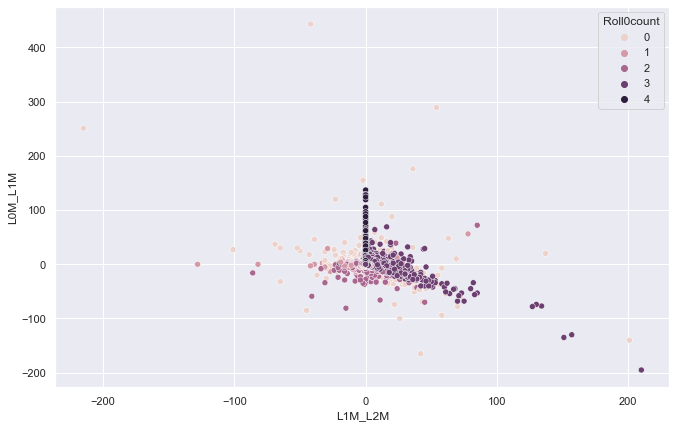

In [44]:
fig, axs = plt.subplots(nrows=1, ncols=1,figsize=(11,7), sharex=True)
sns.scatterplot(data = train_selection , y = 'L0M_L1M' , x =  'L1M_L2M', hue = 'Roll0count')

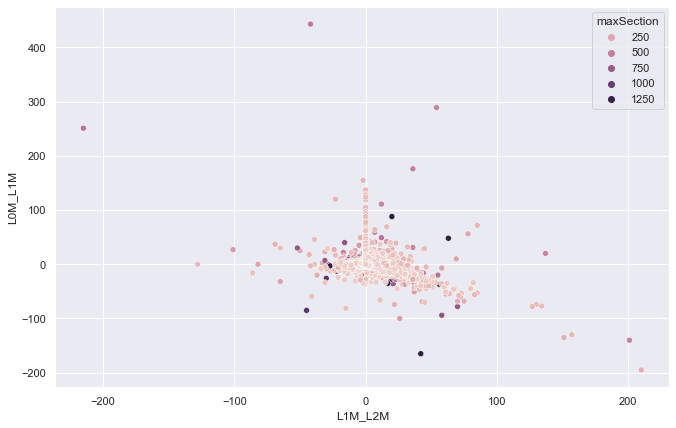

In [45]:
fig, axs = plt.subplots(nrows=1, ncols=1,figsize=(11,7), sharex=True)
sns.scatterplot(data = train_selection , y = 'L0M_L1M' , x =  'L1M_L2M', hue = 'maxSection')

### continue ...

In [46]:
from sklearn.preprocessing import MinMaxScaler
def scaler(dataset, features, target, scaler=None):
    if scaler:
        df = dataset[features + [target]]
        df_scaled = scaler.transform(df)
        dataset_scaled = pd.DataFrame(df_scaled, columns = df.columns, index = df.index)
        return dataset_scaled
    
    else:
        df  = dataset[features + [target]]
        scaler = MinMaxScaler()
        scaler.fit(df)

        dataset_scaled = scaler.transform(df)
        dataset_scaled = pd.DataFrame(dataset_scaled, columns = df.columns, index = df.index)
        return dataset_scaled, scaler

In [47]:
train_scaled, my_scaler = scaler(train_selection, numericals, my_target, scaler=None)
train_dummies = pd.get_dummies(train_selection[categoricals])
train_scaled = pd.concat([train_dummies,train_scaled],axis = 1)

In [48]:
final_features = list(train_dummies.columns) +  numericals

In [49]:
train_scaled.head()

,categVolume_A,categVolume_B,categVolume_C,categVolume_D,categVolume_F,categVolume_G,categVolume_H,categSale_A,categSale_B,categSale_C,...,befExplotion,SumBefExplotion,labeling,meanVarExploItem,meanVarExploShop,countMonth,medianVarL12,SeasonalVariation,HighVarL12,L0M_L1M
1144106,0,0,0,0,0,0,1,1,0,0,...,0.0,0.00,0.0,0.333333,0.380952,0.0,0.288991,0.872257,0.067212,0.308777
1144108,0,0,0,0,0,0,1,0,1,0,...,0.0,0.00,0.0,0.333333,0.380952,0.0,0.284404,1.000000,0.045690,0.305643
1144115,0,0,0,0,0,0,1,0,1,0,...,0.0,0.00,0.0,0.333333,0.380952,0.0,0.284404,1.000000,0.045690,0.324451
1144117,0,0,0,0,0,0,1,0,1,0,...,0.0,0.10,0.0,0.333333,0.380952,0.0,0.275229,0.872257,0.056270,0.307210
1144118,0,0,0,0,0,0,1,0,1,0,...,0.0,0.85,0.0,0.333333,0.380952,0.0,0.284404,0.872257,0.058194,0.305643


In [50]:
train_scaled.shape, train_selection.shape

((154546, 45), (154546, 39))

### ML modeling using ADAboost

In [51]:
X_train = train_scaled[final_features]
Y_train = train_scaled[my_target]

In [52]:
my_base = DecisionTreeRegressor(criterion = 'squared_error', max_depth = 40, min_samples_split = 5, min_samples_leaf = 5 , max_features = 35)
my_ABM = AdaBoostRegressor(base_estimator = my_base, n_estimators=50, learning_rate=0.35, loss='linear')
my_ABM.fit(X_train, Y_train)

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=40,
                                                       max_features=35,
                                                       min_samples_leaf=5,
                                                       min_samples_split=5),
                  learning_rate=0.35)

<b> hold out validation

In [53]:
full_valandtrain = preparing_to_predict(val_data = val_window, train_data = train_window)
full_valandtrain = completion_semi_gold(full_valandtrain)

In [54]:
valandtrain_feature , _ = feature_silver(full_valandtrain)
valandtrain_feature = integration_new_features_map(data = valandtrain_feature, dict_feature= features_dictionary) 

In [55]:
val_selection = features_rows_train_silver(data = valandtrain_feature, features = my_features, target = my_target, dates_back = 1)  ###### check meeeeeeeeeeeeeeeeeeeeeee

In [56]:
val_scaled = scaler(val_selection, numericals, my_target, scaler=my_scaler)
val_dummies = pd.get_dummies(val_selection[categoricals])
val_scaled_full = pd.concat([val_dummies,val_scaled],axis = 1)

In [57]:
X_val = val_scaled_full[final_features]

In [58]:
Y_pred = my_ABM.predict(X_val)

In [59]:
predicted_val = inversed_scale(scaler = my_scaler, data = val_scaled, target_name = my_target, y_pred = Y_pred)

In [60]:
my_lm_plot = consolidation_prediction(data = val_selection, prediction = predicted_val.L0M_L1M.values)

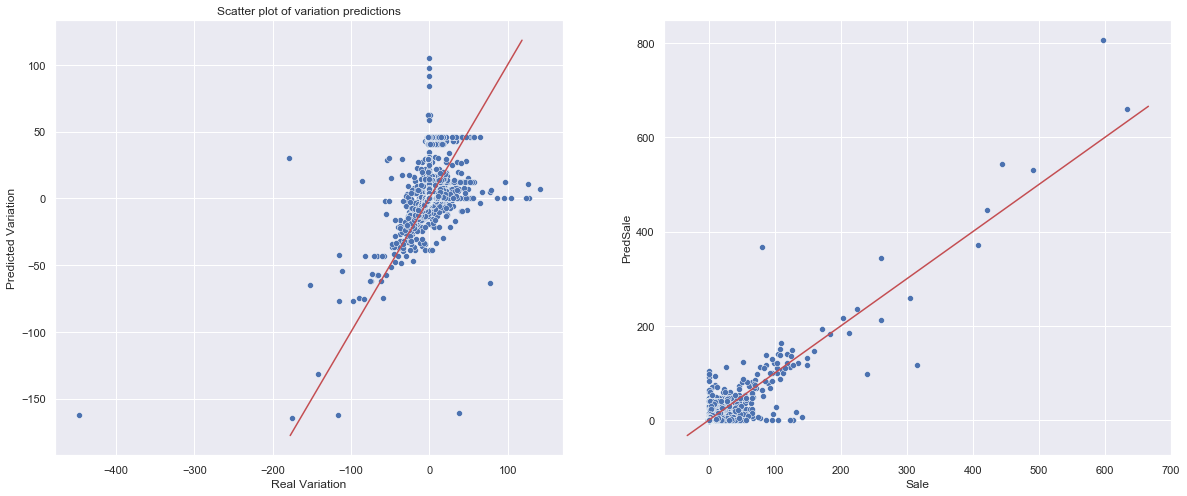

In [61]:
plot_prediction(my_lm_plot)

In [88]:
def My_ML_prediction_on_test(dates_vector, whole_data, model):

    data_result = list()

    for datex in dates_vector:
        train_feature = whole_data[whole_data.Date < datex ].copy()
        valandtrain_feature = whole_data[whole_data.Date == datex ].copy()
        
        train_selection = features_rows_train_silver(data = train_feature, features = my_features, target = my_target, dates_back = 6)
        train_scaled, my_scaler = scaler(train_selection, numericals, my_target, scaler=None)
        train_dummies = pd.get_dummies(train_selection[categoricals])
        train_scaled = pd.concat([train_dummies,train_scaled],axis = 1)
        ### ML train
        X_train = train_scaled[final_features]
        Y_train = train_scaled[my_target]
        model.fit(X_train, Y_train)
        
        ### Test data prepa
        val_selection = features_rows_train_silver(data = valandtrain_feature, features = my_features, target = my_target, dates_back = 1)        
        val_scaled = scaler(val_selection, numericals, my_target, scaler=my_scaler)
        val_dummies = pd.get_dummies(val_selection[categoricals])
        val_scaled_full = pd.concat([val_dummies,val_scaled],axis = 1)
        
        X_val = val_scaled_full[final_features]
        
        ## Prediction
        Y_pred = model.predict(X_val)
        
        ## Saving Result
        predicted_val = inversed_scale(scaler = my_scaler, data = val_scaled, target_name = my_target, y_pred = Y_pred)
        my_lm_plot = consolidation_prediction(data = val_selection, prediction = predicted_val.L0M_L1M.values)
        data_result.append(my_lm_plot)
        #print(f'the prediction over the {datex} data is done')
        
    return pd.concat(data_result)

In [84]:
whole_full = completion_semi_gold(wholedata_silver)
whole_feature, _ = feature_silver(whole_full)
whole_feature = integration_new_features_map(data = whole_feature, dict_feature= features_dictionary) 

In [85]:
#check point
whole_feature.to_csv('intermediate_train_data.csv', header = True, index = False)

In [86]:
whole_feature = pd.read_csv('intermediate_train_data.csv')
whole_feature['Date'] = pd.to_datetime(whole_feature['Date'], format = '%Y-%m-%d')

In [90]:
my_base = DecisionTreeRegressor(criterion = 'squared_error', max_depth = 30, min_samples_split = 5, min_samples_leaf = 5 , max_features = 35)
my_ABM = AdaBoostRegressor(base_estimator = my_base , n_estimators=50, learning_rate=0.05, loss='linear')
my_test_results = My_ML_prediction_on_test( dates_vector = test_dates, whole_data = whole_feature, model = my_ABM)

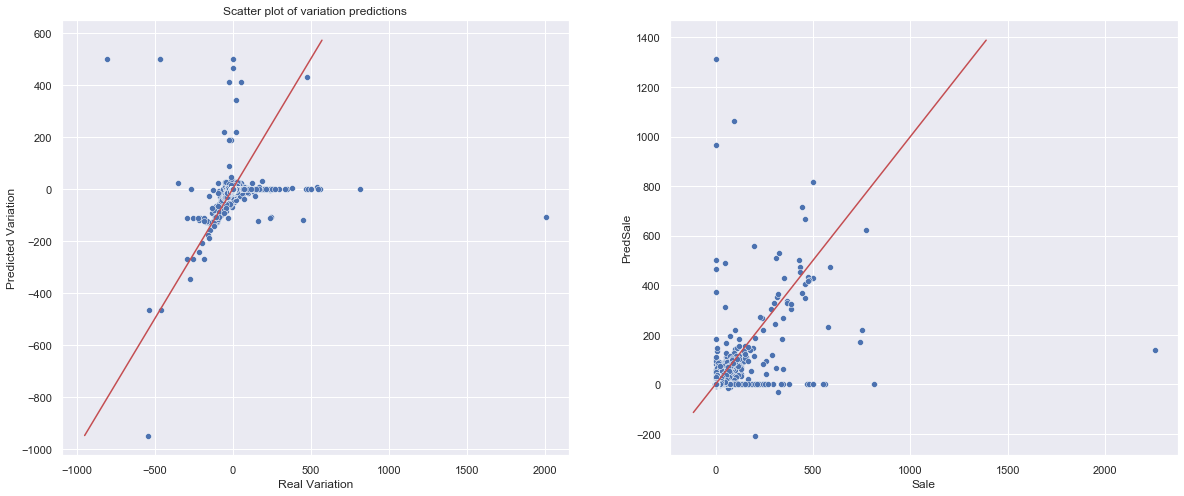

In [91]:
plot_prediction(my_test_results)

In [92]:
rmse_results = plot_metrics(my_test_results)

In [93]:
rmse_results.RMSE.mean()

3.876616961129459

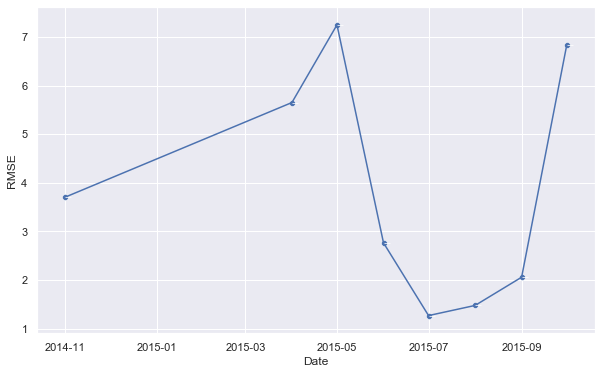

In [94]:
fig, axs = plt.subplots(nrows=1, ncols=1,figsize=(10,6), sharex=True)
ax = sns.lineplot(ax = axs , data = rmse_results, x="Date", y="RMSE", marker = True, )
ax = sns.scatterplot(ax = axs , data = rmse_results, x="Date", y="RMSE", s = 35 )

<b> checking errors

In [95]:
my_test_results_melt = my_test_results.assign(Class = np.where( my_test_results.Sale > 10, 'A',
                                                      np.where( my_test_results.Sale > 7, 'B',
                                                      np.where( my_test_results.Sale > 5, 'C',
                                                      np.where( my_test_results.Sale > 3, 'D','E')))))\
                            .assign(ABSerror = abs(my_test_results.Sale - my_test_results.PredSale))

In [96]:
my_test_results_melt.pivot_table(index = ['Date'], columns = 'Class', values = ['ABSerror'], aggfunc =  lambda x: np.percentile(x, 75) )

ABSerror                                        
Class               A         B         C         D         E
Date                                                         
2014-11-01  29.000000  8.000000  5.941176  3.833333  0.345679
2015-04-01  26.000000  8.300313  5.786716  3.693938  0.420786
2015-05-01  36.500000  7.903372  5.552677  3.694118  0.379310
2015-06-01  18.000000  7.500000  5.648810  3.812817  0.400000
2015-07-01  13.593548  6.813592  5.152778  3.661905  0.444444
2015-08-01  15.000000  7.714286  5.369318  3.811806  0.514563
2015-09-01  22.000000  8.000000  6.000000  3.949865  0.500000
2015-10-01  20.000000  8.142857  6.000000  4.000000  0.500000

In [97]:
my_test_results_melt.pivot_table(index = ['Date'], columns = 'Class', values = ['ABSerror'], aggfunc =  lambda x: np.percentile(x, 100) )

ABSerror                                                 
Class                 A           B           C            D           E
Date                                                                    
2014-11-01   532.200000   15.000000   50.222222    30.000000   45.000000
2015-04-01   813.000000  124.600000   33.000000    13.625000  500.000000
2015-05-01   966.000000   54.692308  141.000000  1308.000000  964.000000
2015-06-01   438.941176   56.333333   14.833333    16.333333   38.200000
2015-07-01   120.000000   11.666667   25.000000    14.166667   30.000000
2015-08-01   146.666667   34.000000   10.166667    13.857143   23.888889
2015-09-01   164.400000   17.000000    7.000000    18.333333   19.428571
2015-10-01  2115.000000   28.600000   34.750000    28.800000   46.888889

I improved but still
check month seasonality - extreme values or extreme variations

### Basic K flod with Parameter tunning

In [70]:
my_adab_models = list()
number_of_machines = 20
machines_labels = [f'machine-{x}' for x in range(1,number_of_machines +1) ]

parameters = { 'Machine':machines_labels,
    'max_depth': [25,30, 40, 55, 30, 25, 19, 34, 50, 35, 25, 24, 34, 30, 55, 45, 24, 18, 44, 29],
    'min_samples_split':[5, 4, 10, 7, 9, 15, 3, 3, 5, 5, 6, 7, 8, 12, 7, 3, 3, 4, 9, 12 ],
    'min_samples_leaf':[10, 7, 12, 5, 4, 3, 3, 3, 15, 12, 9, 3, 3, 4, 5, 9, 12, 15, 10, 10],
    'max_features':[25, 30, 25, 25, 30, 27, 30, 22, 25, 26, 29, 30, 30, 26, 21, 24, 25, 30, 28, 21],
              
    'n_estimators' : [50, 45, 90, 100, 50, 35, 150, 120, 85, 60, 60, 180, 40, 40, 60, 100, 60, 50, 70, 90],
    'learning_rate' : [0.05, 0.12, 0.02, 0.04, 0.004, 0.0003, 0.15, 0.08, 0.001, 0.005, 0.01, 0.005, 0.006, 0.15, 0.0001, 0.025, 0.0025, 0.03, 0.0095, 0.003] }

for i in range(number_of_machines):
    max_depth_param = parameters['max_depth'][i]
    min_samples_split_param = parameters['min_samples_split'][i]
    min_samples_leaf_param = parameters['min_samples_leaf'][i]
    max_features_param = parameters['max_features'][i]
    
    n_estimators_param = parameters['n_estimators'][i]
    learning_rate_param = parameters['learning_rate'][i]
    
    my_base = DecisionTreeRegressor(criterion = 'squared_error', max_depth = max_depth_param, min_samples_split = min_samples_split_param, min_samples_leaf = min_samples_leaf_param , max_features = max_features_param)
    my_adab = AdaBoostRegressor(base_estimator = my_base, n_estimators = n_estimators_param, learning_rate = learning_rate_param, loss='linear')
    my_adab_models.append(my_adab)

parameters_df = pd.DataFrame(parameters)  

In [72]:
def my_kfold_crossval_and_Hptunning(data, models_toTrain):
    models_toTrain = my_adab_models
    data = whole_feature

    results = {'machine label': list(),
        'machine result': list()}

    for machine,i in zip(models_toTrain, range(1,len(models_toTrain) + 1)):
        label = f'machine-{i}'
        results['machine label'].append(label)
        df_result = My_ML_prediction_on_test( dates_vector = test_dates, whole_data = data, model = machine)
        results['machine result'].append(df_result)
        print(label + ' is done')
        
    return results

In [ ]:
results = my_kfold_crossval_and_Hptunning(data = whole_feature, models_toTrain =  my_adab_models)

In [ ]:
results = plot_metrics(my_test_results)

In [ ]:
def consolidated_plot_metrics(data):
    list_dfplot = list()
    for i in range(len(data['machine label'])):
        label = results['machine label'][i]
        result_detail = results['machine result'][i]
        df_plot = plot_metrics(result_detail)
        df_plot['machine'] = label
        list_dfplot.append(df_plot)
    
    return pd.concat(list_dfplot)

In [ ]:
metrics_toplot = consolidated_plot_metrics(results)

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=1,figsize=(15,10), sharex=True)
ax = sns.lineplot(ax = axs , data = metrics_toplot, x="Date", y="RMSE", marker = True, hue = 'machine', legend = False )
ax = sns.scatterplot(ax = axs , data = metrics_toplot, x="Date", y="RMSE", s = 35, hue= 'machine' )